# In this Case Study Lets Cluster the Customers Based on there Spening

## Case Study Details

* You are owing a supermarket mall and through membership cards , you have some basic data about your customers like Customer ID, age, gender, annual income and spending score.
Spending Score is something you assign to the customer based on your defined parameters like customer behavior and purchasing data.

## Problem Statement

* You own the mall and want to understand the customers like who can be easily converge [Target Customers] so that the sense can be given to marketing team and plan the strategy accordingly.

### Import Section

In [110]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans,AgglomerativeClustering,DBSCAN
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import silhouette_score
import plotly.express as px
from validclust import dunn
import seaborn as sns
from sklearn.metrics import pairwise_distances
#!pip3 install umap-learn
from umap import umap_ as UMAP

### Lets Pull the data from kaggle

In [13]:

! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d vjchoudhary7/customer-segmentation-tutorial-in-python
! mkdir clustering_data
!unzip /content/customer-segmentation-tutorial-in-python.zip -d clustering_data


Saving kaggle.json to kaggle.json
mkdir: cannot create directory ‘/root/.kaggle’: File exists
  0% 0.00/1.55k [00:00<?, ?B/s]
100% 1.55k/1.55k [00:00<00:00, 2.64MB/s]
mkdir: cannot create directory ‘clustering_data’: File exists
Archive:  /content/customer-segmentation-tutorial-in-python.zip
  inflating: clustering_data/Mall_Customers.csv  


Lets Load the dataset

In [49]:
dataset = pd.read_csv('/content/clustering_data/Mall_Customers.csv')
dataset.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [50]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


### Data Preperation for unsupervised clustering

In [51]:
dataset = dataset.iloc[:,1:]
dataset.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40


In [52]:
dataset.Gender = dataset['Gender'].map({'Male':0,'Female':1})
dataset.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,0,19,15,39
1,0,21,15,81
2,1,20,16,6
3,1,23,16,77
4,1,31,17,40


In [54]:
scalar = StandardScaler()
scalar_transformer = ColumnTransformer(
    [('standardising', scalar,['Age','Annual Income (k$)','Spending Score (1-100)'])],
    remainder = 'passthrough'
)
dataset = pd.DataFrame(data = scalar_transformer.fit_transform(dataset),columns = ['Age','Annual Income (k$)','Spending Score (1-100)','Gender'])
dataset.head()
                                           

,Age,Annual Income (k$),Spending Score (1-100),Gender
0,-1.424569,-1.738999,-0.434801,0.0
1,-1.281035,-1.738999,1.195704,0.0
2,-1.352802,-1.700830,-1.715913,1.0
3,-1.137502,-1.700830,1.040418,1.0
4,-0.563369,-1.662660,-0.395980,1.0


### 1. Elbow Curve Method

* The elbow method runs k-means clustering (kmeans number of clusters) on the dataset for a range of values of k (say 1 to 10).

* Perform K-means clustering with all these different values of K. For each of the K values, we calculate average distances to the centroid across all data points.
* Plot these points and find the point where the average distance from the centroid falls suddenly (“Elbow”).

<center>
<img src = "https://editor.analyticsvidhya.com/uploads/62725cluster0.PNG" >
</center>

* The curve looks like an elbow. In the above plot, the elbow is at k=3 (i.e. Sum of squared distances falls suddenly) indicating the optimal k for this dataset is 3.

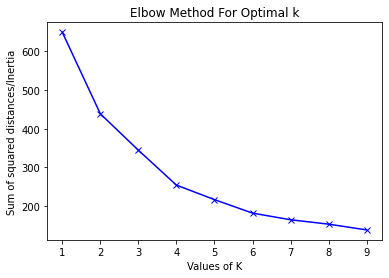

In [71]:
Sum_of_squared_distances = []
K = range(1,10)
for num_clusters in K :
 kmeans = KMeans(n_clusters=num_clusters)
 kmeans.fit(dataset)
 Sum_of_squared_distances.append(kmeans.inertia_)
plt.plot(K,Sum_of_squared_distances,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Sum of squared distances/Inertia') 
plt.title('Elbow Method For Optimal k')
plt.show()



### 2. Silhouette analysis

* The silhouette coefficient or silhouette score kmeans is a measure of how similar a data point is within-cluster (cohesion) compared to other clusters (separation).

1. Select a range of values of k (say 1 to 10).
2. Plot Silhouette coefﬁcient for each value of K.

The equation for calculating the silhouette coefﬁcient for a particular data point:

<center>
<img src = "https://editor.analyticsvidhya.com/uploads/45590cluster1.PNG" >
</center>

* S(i) is the silhouette coefficient of the data point i.
* a(i) is the average distance between i and all the other data points in the cluster to which i belongs.
* b(i) is the average distance from i to all clusters to which i does not belong.

<center>
<img src = "https://editor.analyticsvidhya.com/uploads/90733cluster2.PNG" width="600" height="300" >
</center>

<center>
<img src = "https://editor.analyticsvidhya.com/uploads/56608cluster3.PNG" width="600" height="300" >
</center>


<center>
<img src = "https://editor.analyticsvidhya.com/uploads/42277cluster4.PNG" >
</center>


* We will then calculate the average_silhouette for every k.Then plot the graph between average_silhouette and K.


## Points to remember while calculating silhouette coefficient:

1. The value of the silhouette coefﬁcient is between [-1, 1].
2. A score of 1 denotes the best meaning that the data point i is very compact within the cluster to which it belongs and far away from the other clusters.
3. The worst value is -1. Values near 0 denote overlapping clusters.







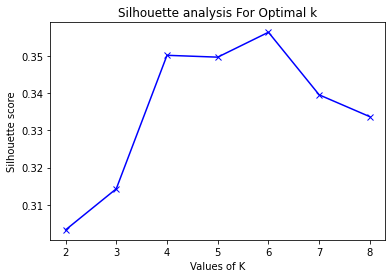

In [75]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
silhouette_avg = []
for num_clusters in range_n_clusters:
 # initialise kmeans
 kmeans = KMeans(n_clusters=num_clusters)
 kmeans.fit(dataset)
 cluster_labels = kmeans.labels_
 
 # silhouette score
 silhouette_avg.append(silhouette_score(dataset, cluster_labels))
plt.plot(range_n_clusters,silhouette_avg,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis For Optimal k')
plt.show()

### DUNN INDEX
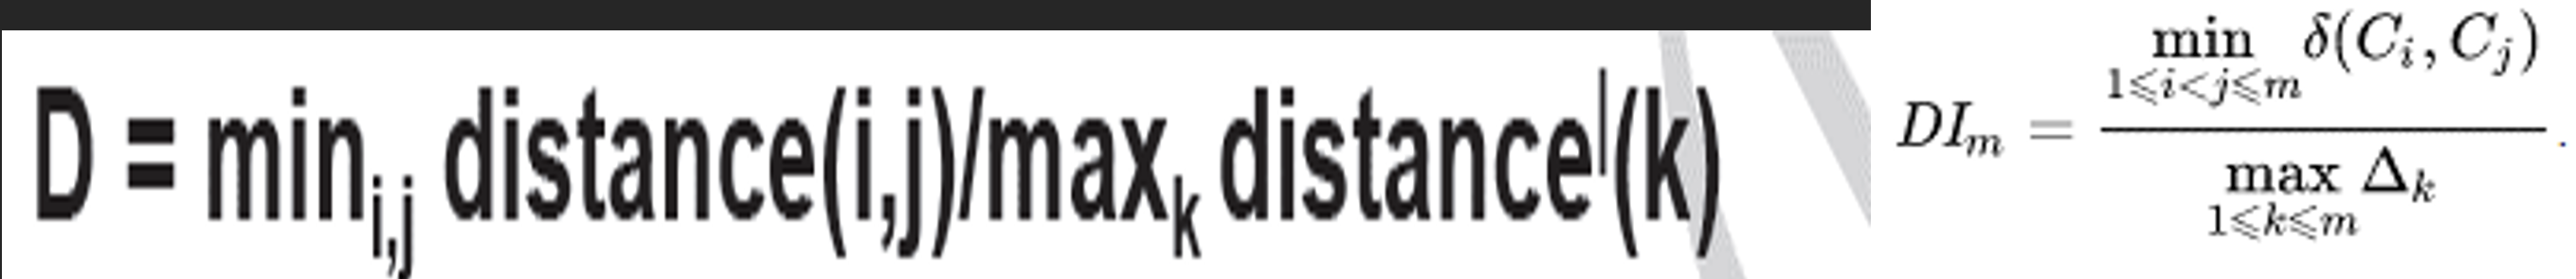

* Distance (i,j) → distance between the farthest points of the clusters Ci and Cj.
* distance|(k) → Intra-Cluster distance
* If D is high, it implies good clustering. And for that the distances between the points in the same cluster should be as smaller as possible, and the distance between the different clusters should be as larger as possible.


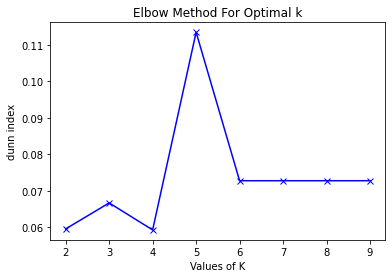

In [92]:
#! pip install git+https://github.com/crew102/validclust.git

Dunn_Index = []
K = range(2,10)
for num_clusters in K :
  kmeans = KMeans(n_clusters=num_clusters)
  kmeans.fit(dataset)
  labels = kmeans.labels_
  dist = pairwise_distances(dataset)
  Dunn_Index.append(dunn(dist,labels))
plt.plot(K,Dunn_Index,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('dunn index') 
plt.title('Elbow Method For Optimal k')
plt.show()

# Based on the elbow, Silhouette and dunn index we selected k = 5

In [94]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(dataset)
labels = kmeans.labels_

In [104]:
transform = TSNE 
trans = transform(n_components=3,perplexity = 30.0)
dataset_3d = trans.fit_transform(dataset)
dataset_3d = np.column_stack((dataset_3d,labels))
fig = px.scatter_3d(pd.DataFrame(dataset_3d), x=0, y=1, z=2,color=3)
fig.update_layout(autosize=False,width=800,height=800)
fig.show()

In [106]:
dataset

,Age,Annual Income (k$),Spending Score (1-100),Gender
0,-1.424569,-1.738999,-0.434801,0.0
1,-1.281035,-1.738999,1.195704,0.0
2,-1.352802,-1.700830,-1.715913,1.0
3,-1.137502,-1.700830,1.040418,1.0
4,-0.563369,-1.662660,-0.395980,1.0
...,...,...,...,...
195,-0.276302,2.268791,1.118061,1.0
196,0.441365,2.497807,-0.861839,1.0
197,-0.491602,2.497807,0.923953,0.0
198,-0.491602,2.917671,-1.250054,0.0


In [108]:
dataset_scatter = dataset.copy()
dataset_scatter['label'] = labels
dataset_scatter.head()



,Age,Annual Income (k$),Spending Score (1-100),Gender,label
0,-1.424569,-1.738999,-0.434801,0.0,3
1,-1.281035,-1.738999,1.195704,0.0,0
2,-1.352802,-1.700830,-1.715913,1.0,3
3,-1.137502,-1.700830,1.040418,1.0,0
4,-0.563369,-1.662660,-0.395980,1.0,3



******************************
Age
******************************



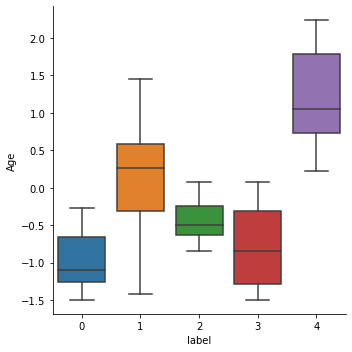


******************************
Annual Income (k$)
******************************



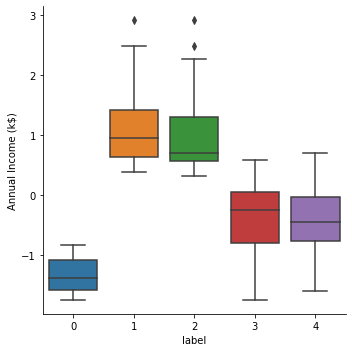


******************************
Spending Score (1-100)
******************************



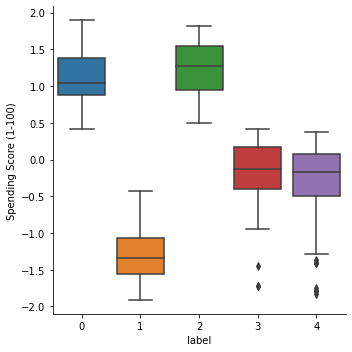


******************************
Gender
******************************



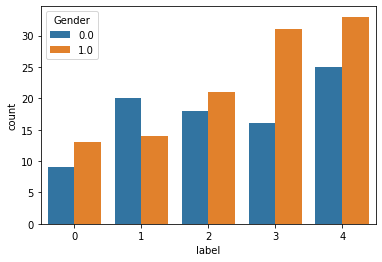

In [126]:
for column in ['Age','Annual Income (k$)','Spending Score (1-100)']:
  print('\n'+'*'* 30)
  print(column)
  print('*'* 30 + '\n')
  sns.catplot(data = dataset_scatter,y = column, x = 'label',kind = 'box')
  plt.show()
  
for column in ['Gender']:
  print('\n'+'*'* 30)
  print(column)
  print('*'* 30 + '\n')
  sns.countplot(data = dataset_scatter,x = 'label',hue = 'Gender')
  plt.show()